## 1. 环境准备

In [1]:
import sys
sys.path.append('..')

import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

# 导入格子检测模块
from src.preprocessing.grid_detection import (
    detect_grid_lines, 
    generate_grid_cells,
    cluster_lines_by_position,
    merge_line_cluster
)

print("✓ 模块导入成功")

✓ 模块导入成功


## 2. 加载图像

✓ 加载图像: (2900, 2170, 3)


c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


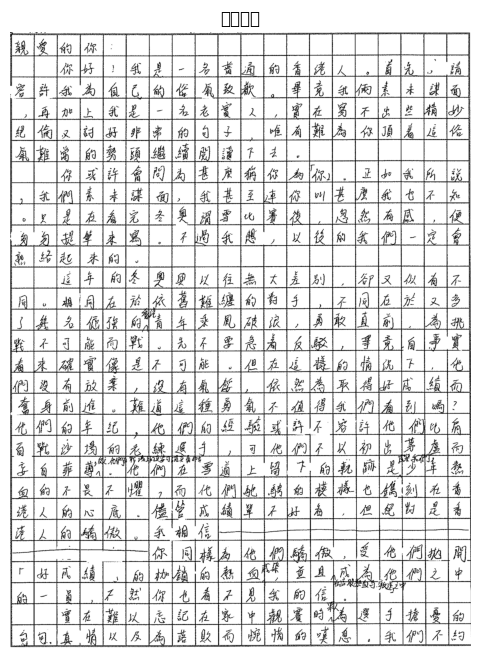

In [2]:
# 项目根目录
project_root = Path('..').resolve()

# 加载图像
img_path = project_root / 'output' / 'temp_cropped.png'
img = cv2.imread(str(img_path))

if img is None:
    raise FileNotFoundError(f"无法加载图像: {img_path}\n请确保文件存在")

print(f"✓ 加载图像: {img.shape}")

# 转换为灰度图
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 显示原图
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('原始图像')
plt.axis('off')
plt.show()

## 3. 检测格子线

In [3]:
# 检测格子线
print("检测格子线...")
lines = detect_grid_lines(gray)
horizontal_lines = lines['horizontal']
vertical_lines = lines['vertical']

print(f"✓ 检测到横线: {len(horizontal_lines)} 条")
print(f"✓ 检测到竖线: {len(vertical_lines)} 条")

检测格子线...
✓ 检测到横线: 259 条
✓ 检测到竖线: 190 条


## 4. 详细分析竖线检测结果

In [7]:
print("=" * 80)
print("竖线检测详细分析")
print("=" * 80)

# 原始检测到的竖线
print(f"\n1. 原始检测到的竖线数量: {len(vertical_lines)}")
print(f"   竖线格式: (x_avg, y1, y2, angle)")
print(f"   前 5 条竖线:")
for i, line in enumerate(vertical_lines[:5]):
    print(f"      {i}: x={line[0]}, y1={line[1]}, y2={line[2]}, angle={line[3]:.2f}°, length={line[2]-line[1]}")

# 合并相近的竖线
print(f"\n2. 合并相近的竖线 (阈值=10像素)...")
v_clusters = cluster_lines_by_position(vertical_lines, 'vertical', 20)
print(f"   聚类数量: {len(v_clusters)}")

# 显示聚类详情
print(f"\n   聚类详情:")
for i, cluster in enumerate(v_clusters[:10]):
    if len(cluster) > 1:
        x_positions = [line[0] for line in cluster]
        print(f"      聚类 {i}: {len(cluster)} 条线, x范围=[{min(x_positions)}, {max(x_positions)}], 跨度={max(x_positions)-min(x_positions)}px")

# 合并后的竖线
v_merged = [merge_line_cluster(cluster, 'vertical') for cluster in v_clusters]
print(f"\n3. 合并后的竖线数量: {len(v_merged)}")

# 过滤短竖线
print(f"\n4. 过滤短竖线 (长度 < 最大长度的 50%)...")
v_lengths = [line[2] - line[1] for line in v_merged]
max_v_length = max(v_lengths)
print(f"   最大竖线长度: {max_v_length} 像素")
print(f"   过滤阈值: {max_v_length / 2:.0f} 像素")

v_filtered = [line for line, length in zip(v_merged, v_lengths) 
              if length >= max_v_length / 2]
filtered_lengths = [line[2] - line[1] for line in v_filtered]

print(f"   过滤后的竖线数量: {len(v_filtered)}")
print(f"   过滤掉的竖线数量: {len(v_merged) - len(v_filtered)}")

# 显示被过滤的竖线
if len(v_merged) > len(v_filtered):
    print(f"\n   被过滤的竖线:")
    for line, length in zip(v_merged, v_lengths):
        if length < max_v_length / 2:
            print(f"      x={line[0]}, length={length}px (< {max_v_length/2:.0f}px)")

print(f"\n5. 最终竖线数量: {len(v_filtered)} 条")
print(f"   预期生成的列数: {len(v_filtered) - 1} 列")

print("\n" + "=" * 80)

竖线检测详细分析

1. 原始检测到的竖线数量: 190
   竖线格式: (x_avg, y1, y2, angle)
   前 5 条竖线:
      0: x=111, y1=1002, y2=2895, angle=90.00°, length=1893
      1: x=219, y1=110, y2=2440, angle=90.00°, length=2330
      2: x=543, y1=398, y2=2894, angle=90.00°, length=2496
      3: x=1, y1=292, y2=2428, angle=90.00°, length=2136
      4: x=9, y1=1, y2=251, angle=90.00°, length=250

2. 合并相近的竖线 (阈值=10像素)...
   聚类数量: 21

   聚类详情:
      聚类 0: 11 条线, x范围=[1, 9], 跨度=8px
      聚类 1: 4 条线, x范围=[111, 115], 跨度=4px
      聚类 2: 5 条线, x范围=[219, 223], 跨度=4px
      聚类 3: 5 条线, x范围=[327, 333], 跨度=6px
      聚类 4: 7 条线, x范围=[435, 441], 跨度=6px
      聚类 5: 6 条线, x范围=[543, 549], 跨度=6px
      聚类 6: 7 条线, x范围=[651, 657], 跨度=6px
      聚类 7: 9 条线, x范围=[759, 766], 跨度=7px
      聚类 8: 7 条线, x范围=[868, 874], 跨度=6px
      聚类 9: 7 条线, x范围=[976, 982], 跨度=6px

3. 合并后的竖线数量: 21

4. 过滤短竖线 (长度 < 最大长度的 50%)...
   最大竖线长度: 2895 像素
   过滤阈值: 1448 像素
   过滤后的竖线数量: 21
   过滤掉的竖线数量: 0

5. 最终竖线数量: 21 条
   预期生成的列数: 20 列



## 5. 分析竖线位置和间距

In [8]:
# 提取竖线 x 坐标
v_positions = sorted([line[0] for line in v_filtered])

print("=" * 80)
print("竖线位置和间距分析")
print("=" * 80)

print(f"\n竖线 x 坐标: {v_positions}")

# 计算相邻竖线间距
if len(v_positions) > 1:
    gaps = [v_positions[i+1] - v_positions[i] for i in range(len(v_positions)-1)]
    
    print(f"\n相邻竖线间距:")
    for i, gap in enumerate(gaps):
        marker = ""
        if i == len(gaps) - 1:
            marker = "  ← 最后一个间距"
        print(f"  第 {i:2d} - {i+1:2d} 条竖线: {gap:4d} 像素{marker}")
    
    avg_gap = np.mean(gaps)
    std_gap = np.std(gaps)
    
    print(f"\n统计信息:")
    print(f"  平均间距: {avg_gap:.1f} 像素")
    print(f"  标准差: {std_gap:.1f} 像素")
    print(f"  最小间距: {min(gaps)} 像素")
    print(f"  最大间距: {max(gaps)} 像素")
    
    # 找出异常间距
    threshold_small = avg_gap * 0.3  # < 30% 平均间距
    threshold_large = avg_gap * 1.5  # > 150% 平均间距
    
    abnormal_small = [(i, gaps[i]) for i in range(len(gaps)) if gaps[i] < threshold_small]
    abnormal_large = [(i, gaps[i]) for i in range(len(gaps)) if gaps[i] > threshold_large]
    
    if abnormal_small:
        print(f"\n⚠️  异常小的间距（< 30% 平均间距 = {threshold_small:.1f}px）:")
        for idx, gap in abnormal_small:
            print(f"  第 {idx} - {idx+1} 条竖线之间: {gap} 像素")
            print(f"    → 可能是重复检测或误检测")
    
    if abnormal_large:
        print(f"\n⚠️  异常大的间距（> 150% 平均间距 = {threshold_large:.1f}px）:")
        for idx, gap in abnormal_large:
            print(f"  第 {idx} - {idx+1} 条竖线之间: {gap} 像素")
            print(f"    → 可能漏检了中间的竖线")

print("\n" + "=" * 80)

竖线位置和间距分析

竖线 x 坐标: [5, 113, 221, 329, 438, 546, 654, 762, 871, 979, 1088, 1196, 1304, 1411, 1519, 1627, 1736, 1842, 1952, 2059, 2163]

相邻竖线间距:
  第  0 -  1 条竖线:  108 像素
  第  1 -  2 条竖线:  108 像素
  第  2 -  3 条竖线:  108 像素
  第  3 -  4 条竖线:  109 像素
  第  4 -  5 条竖线:  108 像素
  第  5 -  6 条竖线:  108 像素
  第  6 -  7 条竖线:  108 像素
  第  7 -  8 条竖线:  109 像素
  第  8 -  9 条竖线:  108 像素
  第  9 - 10 条竖线:  109 像素
  第 10 - 11 条竖线:  108 像素
  第 11 - 12 条竖线:  108 像素
  第 12 - 13 条竖线:  107 像素
  第 13 - 14 条竖线:  108 像素
  第 14 - 15 条竖线:  108 像素
  第 15 - 16 条竖线:  109 像素
  第 16 - 17 条竖线:  106 像素
  第 17 - 18 条竖线:  110 像素
  第 18 - 19 条竖线:  107 像素
  第 19 - 20 条竖线:  104 像素  ← 最后一个间距

统计信息:
  平均间距: 107.9 像素
  标准差: 1.2 像素
  最小间距: 104 像素
  最大间距: 110 像素



## 6. 可视化竖线检测结果

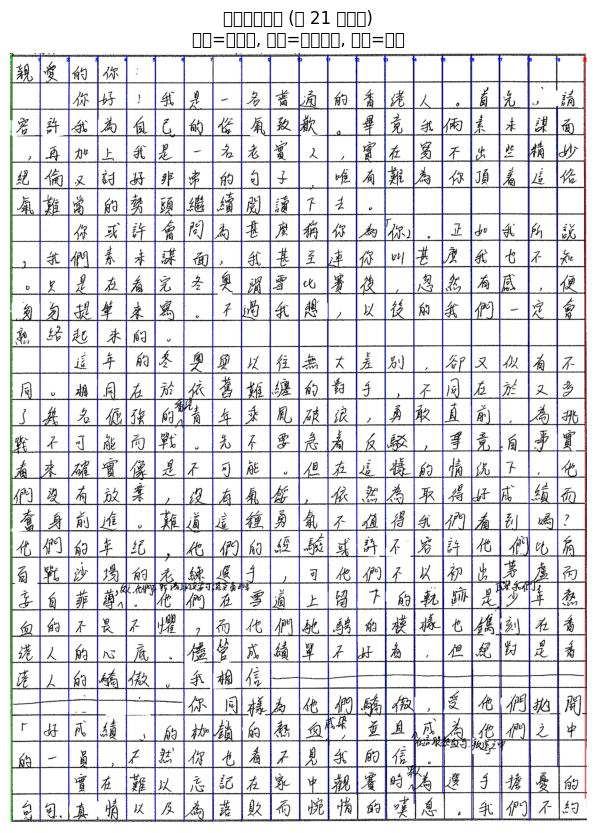

✓ 可视化完成
  绿色线: 第一条竖线 (左边界)
  蓝色线: 中间的竖线
  红色线: 最后一条竖线 (右边界)


In [9]:
# 创建可视化图像
vis_img = img.copy()

# 绘制所有竖线
for i, line in enumerate(v_filtered):
    x, y1, y2, angle = line
    
    # 不同颜色标记不同的竖线
    if i == 0:
        color = (0, 255, 0)  # 绿色：第一条
    elif i == len(v_filtered) - 1:
        color = (0, 0, 255)  # 红色：最后一条
    else:
        color = (255, 0, 0)  # 蓝色：中间的
    
    cv2.line(vis_img, (x, y1), (x, y2), color, 2)
    
    # 标注竖线编号
    cv2.putText(vis_img, str(i), (x-10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# 显示
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.title(f'竖线检测结果 (共 {len(v_filtered)} 条竖线)\n绿色=第一条, 红色=最后一条, 蓝色=中间')
plt.axis('off')
plt.show()

print(f"✓ 可视化完成")
print(f"  绿色线: 第一条竖线 (左边界)")
print(f"  蓝色线: 中间的竖线")
print(f"  红色线: 最后一条竖线 (右边界)")

## 7. 放大查看最后几条竖线

最后 3 条竖线详情:

  第 19 条竖线:
    x 坐标: 2059
    y 范围: [199, 2689]
    长度: 2490 像素
    角度: 90.00°

  第 20 条竖线:
    x 坐标: 2162
    y 范围: [3, 2444]
    长度: 2441 像素
    角度: 90.00°

  第 21 条竖线:
    x 坐标: 2168
    y 范围: [1083, 2807]
    长度: 1724 像素
    角度: 90.00°


c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25918 (\N{CJK UNIFIED IDEOGRAPH-653E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26597 (\N{CJK UNIFIED IDEOGRAPH-67E5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30475 (\N{CJK UNIFIED IDEOGRAPH-770B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-

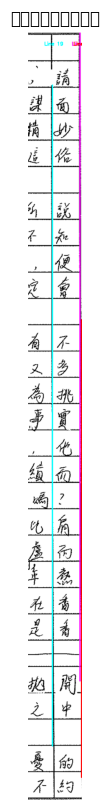


✓ 放大区域: x=[1968, 2170]


In [7]:
# 查看最后 3 条竖线的详细情况
if len(v_filtered) >= 3:
    last_3_lines = v_filtered[-3:]
    last_3_positions = v_positions[-3:]
    
    print("最后 3 条竖线详情:")
    for i, (line, x_pos) in enumerate(zip(last_3_lines, last_3_positions)):
        idx = len(v_filtered) - 3 + i
        print(f"\n  第 {idx} 条竖线:")
        print(f"    x 坐标: {x_pos}")
        print(f"    y 范围: [{line[1]}, {line[2]}]")
        print(f"    长度: {line[2] - line[1]} 像素")
        print(f"    角度: {line[3]:.2f}°")
    
    # 裁剪并放大最右侧区域
    rightmost_x = last_3_positions[-1]
    crop_x1 = max(0, rightmost_x - 200)
    crop_x2 = min(img.shape[1], rightmost_x + 50)
    
    cropped = img[:, crop_x1:crop_x2]
    
    # 在裁剪图上标注竖线
    vis_cropped = cropped.copy()
    for i, (line, x_pos) in enumerate(zip(last_3_lines, last_3_positions)):
        x_local = x_pos - crop_x1
        idx = len(v_filtered) - 3 + i
        
        if idx == len(v_filtered) - 1:
            color = (0, 0, 255)  # 红色：最后一条
        elif idx == len(v_filtered) - 2:
            color = (255, 0, 255)  # 紫色：倒数第二条
        else:
            color = (255, 255, 0)  # 青色：倒数第三条
        
        cv2.line(vis_cropped, (x_local, line[1]), (x_local, line[2]), color, 3)
        cv2.putText(vis_cropped, f"Line {idx}", (x_local-30, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(vis_cropped, cv2.COLOR_BGR2RGB))
    plt.title('放大查看最右侧竖线')
    plt.axis('off')
    plt.show()
    
    print(f"\n✓ 放大区域: x=[{crop_x1}, {crop_x2}]")

## 8. 生成格子并查看结果

生成的格子数量: 609
网格大小: 29 行 × 21 列

⚠️  预期: 20 列
实际: 21 列

❌ 多出了 1 列！

第 20 列示例格子:
  x 范围: [2059, 2162]
  宽度: 103 像素

第 21 列示例格子:
  x 范围: [2162, 2168]
  宽度: 6 像素

显示第 21 列的部分格子:


C:\Users\Quenton\AppData\Local\Temp\ipykernel_21444\1155288946.py:47: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_21444\1155288946.py:47: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_21444\1155288946.py:47: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_21444\1155288946.py:47: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_21444\1155288946.py:47: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_21444\1155288946.py:47: UserWarning: Gl

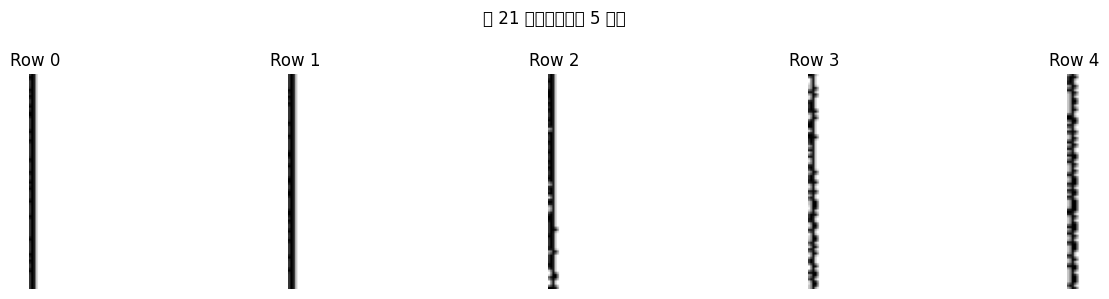

In [8]:
# 生成格子
cells = generate_grid_cells(horizontal_lines, vertical_lines, img.shape[:2])

print(f"生成的格子数量: {len(cells)}")

# 统计行列数
if cells:
    rows = max([cell['row'] for cell in cells]) + 1
    cols = max([cell['col'] for cell in cells]) + 1
    
    print(f"网格大小: {rows} 行 × {cols} 列")
    print(f"\n⚠️  预期: 20 列")
    print(f"实际: {cols} 列")
    
    if cols > 20:
        print(f"\n❌ 多出了 {cols - 20} 列！")
        
        # 查看第 20 列和第 21 列的格子
        col_20_cells = [c for c in cells if c['col'] == 19]  # 第 20 列 (索引 19)
        col_21_cells = [c for c in cells if c['col'] == 20]  # 第 21 列 (索引 20)
        
        if col_20_cells:
            sample_20 = col_20_cells[0]
            print(f"\n第 20 列示例格子:")
            print(f"  x 范围: [{sample_20['x1']}, {sample_20['x2']}]")
            print(f"  宽度: {sample_20['x2'] - sample_20['x1']} 像素")
        
        if col_21_cells:
            sample_21 = col_21_cells[0]
            print(f"\n第 21 列示例格子:")
            print(f"  x 范围: [{sample_21['x1']}, {sample_21['x2']}]")
            print(f"  宽度: {sample_21['x2'] - sample_21['x1']} 像素")
            
            # 显示第 21 列的格子
            print(f"\n显示第 21 列的部分格子:")
            fig, axes = plt.subplots(1, min(5, len(col_21_cells)), figsize=(15, 3))
            if len(col_21_cells) == 1:
                axes = [axes]
            
            for i, (ax, cell) in enumerate(zip(axes, col_21_cells[:5])):
                cell_img = img[cell['y1']:cell['y2'], cell['x1']:cell['x2']]
                ax.imshow(cv2.cvtColor(cell_img, cv2.COLOR_BGR2RGB))
                ax.set_title(f"Row {cell['row']}")
                ax.axis('off')
            
            plt.suptitle('第 21 列的格子（前 5 个）')
            plt.tight_layout()
            plt.show()
    elif cols == 20:
        print(f"\n✓ 列数正确！")
    else:
        print(f"\n⚠️  列数少于预期！")

## 9. 诊断总结和建议

In [9]:
print("=" * 80)
print("诊断总结")
print("=" * 80)

print(f"\n检测到的竖线数量: {len(v_filtered)}")
print(f"生成的列数: {cols if cells else 0}")
print(f"预期列数: 20")

if cols > 20:
    print(f"\n问题确认: 多出了 {cols - 20} 列")
    
    # 分析可能的原因
    if abnormal_small:
        print(f"\n可能原因 1: 重复检测")
        print(f"  发现 {len(abnormal_small)} 个异常小的间距")
        print(f"  建议: 增大合并阈值（merge_threshold）从 10 提升到 15-20")
    
    # 检查最后一条线
    if len(v_positions) >= 2:
        last_gap = v_positions[-1] - v_positions[-2]
        if last_gap < avg_gap * 0.5:
            print(f"\n可能原因 2: 图像边缘被误检测")
            print(f"  最后一条竖线距离倒数第二条只有 {last_gap} 像素")
            print(f"  远小于平均间距 {avg_gap:.1f} 像素")
            print(f"  建议: 在生成格子前，移除图像边缘附近的竖线")

print("\n" + "=" * 80)

诊断总结

检测到的竖线数量: 22
生成的列数: 21
预期列数: 20

问题确认: 多出了 1 列

可能原因 1: 重复检测
  发现 1 个异常小的间距
  建议: 增大合并阈值（merge_threshold）从 10 提升到 15-20

可能原因 2: 图像边缘被误检测
  最后一条竖线距离倒数第二条只有 6 像素
  远小于平均间距 103.0 像素
  建议: 在生成格子前，移除图像边缘附近的竖线

